In [1]:
import praw
import snscrape
import requests
import requests.auth
from tqdm import tqdm

/opt/anaconda3/envs/sentiment_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [1]:
import scripts.credentials as cd
import pandas as pd

In [3]:
reddit = praw.Reddit(
    client_id = cd.client_id,
    client_secret = cd.client_secret,
    user_agent = cd.user_agent,
    user_name = cd.user_name,
    password = cd.password,
    requested_scopes=["read", "search"]
)

In [4]:
from datetime import datetime

In [5]:
def fetch_posts(subreddit_name, search_term, limit = 100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    try:
        for post in tqdm(subreddit.search(search_term, limit = limit, time_filter = "month"), desc = "Fetching posts"):
            post_data = {
                'title' : post.title,
                'text' : post.selftext,
                'score' : post.score,
                'upvote_ratio' : post.upvote_ratio,
                "created_utc": datetime.fromtimestamp(post.created_utc).__format__('%m-%d-%Y'),
                "author": str(post.author),
                "url": post.url,
            }
            posts.append(post_data)
    except Exception as e:
        print(f"Error fetching posts: {e}")
    
    return pd.DataFrame(posts)

df = fetch_posts("Cryptocurrency", "BTC", limit=500)
df.to_csv("reddit_posts.csv", index=False)
print(f"Collected {len(df)} posts.")

Fetching posts: 167it [00:02, 70.05it/s]

Collected 167 posts.


In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sainivasrangaraju/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["sentiment_label"] = df["sentiment"].apply(
    lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral"
)

print(df[["text", "sentiment", "sentiment_label"]].head())

                                                text  sentiment  \
0                                                        0.0000   
1                                                        0.0000   
2                                                        0.0000   
3                                                        0.0000   
4  The last time I did an update eth was 10% away...     0.1634   

  sentiment_label  
0         neutral  
1         neutral  
2         neutral  
3         neutral  
4        positive  


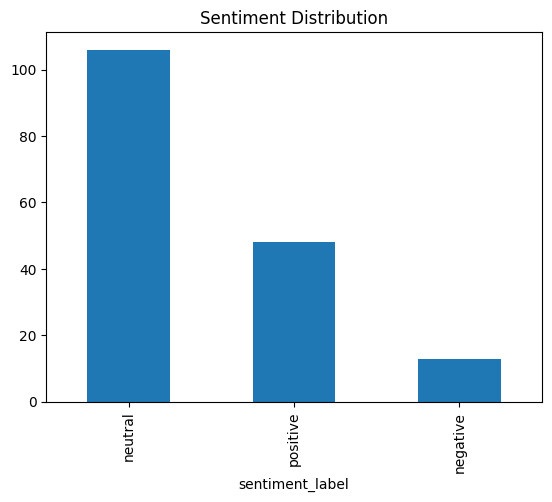

In [8]:
import matplotlib.pyplot as plt

df["sentiment_label"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.show()

In [10]:
import tweepy
import pandas as pd

client = tweepy.Client(bearer_token=cd.bearerToken)

query = "Bitcoin OR BTC -is:retweet lang:en"
tweets = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'text'], max_results=100)

data = [{"date": tweet.created_at, "text": tweet.text} for tweet in tweets.data]
df = pd.DataFrame(data)
print(df.head())


TooManyRequests: 429 Too Many Requests
Too Many Requests

In [1]:
def get_btc_prices(days=30):
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
    df = df[['date', 'price']]
    return df

btc_df = get_btc_prices(days=30)
print(btc_df.head())

NameError: name 'requests' is not defined